<a href="https://colab.research.google.com/github/victorfelipe12/Projeto-BD/blob/main/analise_dengue_sp_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instala as bibliotecas
!pip install dask[complete] pandas geopandas plotly matplotlib pyarrow openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00


In [ ]:
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import requests, zipfile, io

In [133]:
# Monta o Google Drive
from google.colab import drive
drive.mount('/content/drive')

CSV_DENGUE = '/content/drive/MyDrive/Dengue/Bases de Dados/DENGBR24.csv'
EXCEL_INMET = '/content/drive/MyDrive/Dengue/Bases de Dados/inmet_sp.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Arquivos de entrada (Bases de Dados)

## Dengue

In [39]:
# Lê o arquivo com as informações de casos de dengue com Dask
df_dengue = dd.read_csv(CSV_DENGUE, assume_missing=True, dtype=str, encoding='latin1', sep=',')
df_dengue.columns = df_dengue.columns.str.strip()  # remove espaços

In [67]:
# Filtra o municipio de São Paulo
df_dengue['ID_MUNICIP'] = df_dengue['ID_MUNICIP'].str.strip()
df_dengue = df_dengue[df_dengue['ID_MUNICIP'] == '355030']

# Converter a coluna de data
df_dengue['DT_NOTIFIC'] = dd.to_datetime(df_dengue['DT_NOTIFIC'], errors='coerce')

In [69]:
# Decodifica NU_IDADE_N (anos)
def decode_idade(valor):
    try:
        if pd.isna(valor):
            return None
        valor = str(valor).zfill(4)
        unidade, numero = int(valor[0]), int(valor[1:])
        if unidade == 1:  # Horas
            return 0
        elif unidade == 2:  # Dias
            return 0
        elif unidade == 3:  # Meses
            return numero / 12
        elif unidade == 4:  # Anos
            return numero
        else:
            return None
    except:
        return None

df_dengue['IDADE_ANOS'] = df_dengue['NU_IDADE_N'].map_partitions(lambda s: s.apply(decode_idade), meta=('IDADE_ANOS', 'float'))

In [71]:
# Classificação final (CLASSI_FIN)

map_classi = {
    " ": "Ignorado",
    "0": "Ignorado",
    "9": "Ignorado",
    "1": "Confirmado",
    "2": "Descartado",
    "8": "Inconclusivo"
}
df_dengue['CLASSI_DESC'] = df_dengue['CLASSI_FIN'].map(map_classi)

/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_collection.py:4208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map function that you are using.
  Before: .map(func)
  After:  .map(func, meta=('CLASSI_FIN', 'object'))

  warnings.warn(meta_warning(meta, method="map"))


In [111]:
# Agregação mensal com Dask
casos_mes = df_dengue.groupby(df_dengue['DT_NOTIFIC'].dt.month).size().compute()
casos_mes = casos_mes.reset_index()
casos_mes.columns = ['MES', 'CASOS']

# Cria a coluna PERIODO como datetime para 2024
casos_mes['PERIODO'] = pd.to_datetime('2024-' + casos_mes['MES'].astype(str) + '-01')

casos_mes

,MES,CASOS,PERIODO
0,3,123604,2024-03-01
1,5,196180,2024-05-01
2,7,15124,2024-07-01
3,8,6402,2024-08-01
4,10,2544,2024-10-01
5,12,1552,2024-12-01
6,1,7151,2024-01-01
7,2,35580,2024-02-01
8,4,206690,2024-04-01
9,6,56379,2024-06-01


In [73]:
# Casos por dia
df_dengue['DATA'] = df_dengue['DT_NOTIFIC'].dt.floor('D')
casos_dia = df_dengue.groupby('DATA').size()
casos_dia_pd = casos_dia.compute().reset_index(name='CASOS')

## INMET

In [155]:
# Lê Excel com Pandas
df_inmet = pd.read_excel(EXCEL_INMET, engine='openpyxl')
df_inmet.columns = df_inmet.columns.str.strip()

# Converte data e precipitação
df_inmet['Data'] = pd.to_datetime(df_inmet['Data'], errors='coerce')
df_inmet['PRECIPITACAO'] = pd.to_numeric(df_inmet[precip_col], errors='coerce')

# Converte para Dask (
df_inmet_dd = dd.from_pandas(df_inmet, npartitions=4)

# Cria a coluna de período mensal
df_inmet_dd['MES'] = df_inmet_dd['Data'].dt.to_period('M')

# Agregação de precipitação por mês
precip_mes_dd = df_inmet_dd.groupby('MES')['PRECIPITACAO'].sum().reset_index()

# Computa para Pandas
precip_mes = precip_mes_dd.compute()

# Cria a coluna PERIODO como datetime
precip_mes['PERIODO'] = precip_mes['MES'].apply(lambda p: pd.Timestamp(year=p.year, month=p.month, day=1))

# 5Merge dengue + INMET mensal
df_merge_mes = pd.merge(
    casos_mes[['PERIODO','CASOS']],
    precip_mes[['PERIODO','PRECIPITACAO']],
    on='PERIODO',
    how='left'
)

df_merge_mes['PRECIPITACAO'] = df_merge_mes['PRECIPITACAO'].fillna(0)

# Visualiza o resultado
print(df_merge_mes)

      PERIODO   CASOS  PRECIPITACAO
0  2024-03-01  123604         337.2
1  2024-05-01  196180         115.4
2  2024-07-01   15124         139.4
3  2024-08-01    6402         119.0
4  2024-10-01    2544         270.6
5  2024-12-01    1552         433.6
6  2024-01-01    7151         685.4
7  2024-02-01   35580         486.4
8  2024-04-01  206690          90.8
9  2024-06-01   56379           5.8
10 2024-09-01    3698          42.6
11 2024-11-01    1729         286.2


# Análise

In [156]:
# converter Period -> timestamp (primeiro dia do mês) para plot
if pd.api.types.is_period_dtype(df_merge_mes['PERIODO'].dtype):
    df_merge_mes['PERIODO'] = df_merge_mes['PERIODO'].dt.to_timestamp

/tmp/ipython-input-3006513395.py:2: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(df_merge_mes['PERIODO'].dtype):


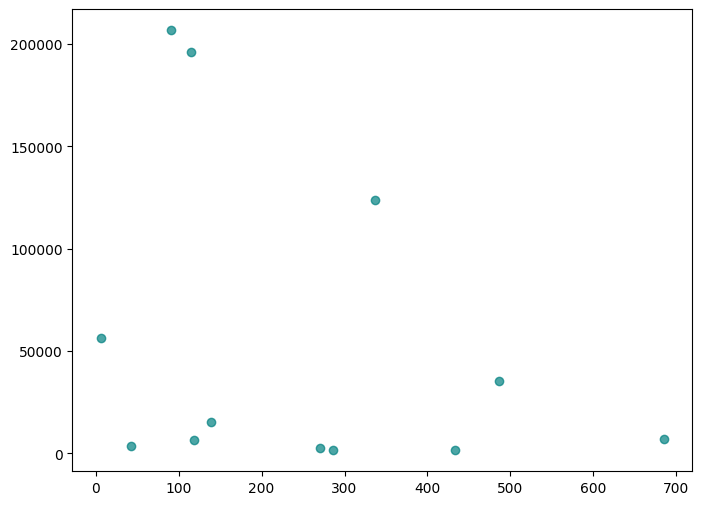

In [157]:
# Gera scatter plot com linha de regressão
plt.figure(figsize=(8,6))
x = df_merge_mes['PRECIPITACAO'].values
y = df_merge_mes['CASOS'].values


plt.scatter(x, y, alpha=0.7, color='teal', label='meses')

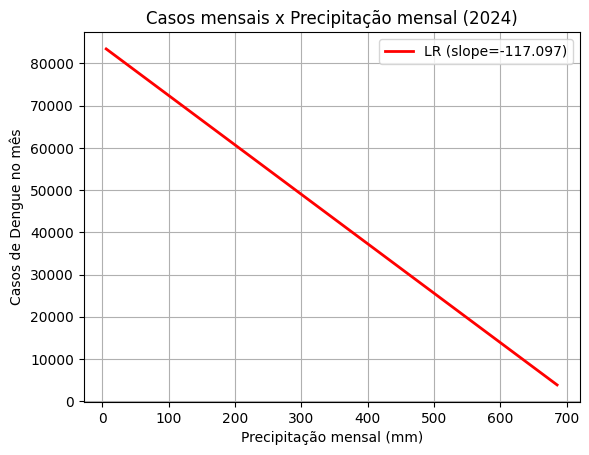

In [158]:
import numpy as np
# Regressão linear simples (polyfit)
if len(x) >= 2 and not np.all(np.isnan(x)) and not np.all(np.isnan(y)):
    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() >= 2:
        coefs = np.polyfit(x[mask], y[mask], 1)
        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = np.polyval(coefs, x_line)
        plt.plot(x_line, y_line, color='red', linewidth=2, label=f'LR (slope={coefs[0]:.3f})')

plt.xlabel("Precipitação mensal (mm)")
plt.ylabel("Casos de Dengue no mês")
plt.title("Casos mensais x Precipitação mensal (2024)")
plt.legend()
plt.grid(True)
plt.show()

In [159]:
# ----- Correlação -----
from scipy.stats import pearsonr, spearmanr

# Pearson
pearson_corr, pearson_p = pearsonr(df_merge_mes['PRECIPITACAO'], df_merge_mes['CASOS'])
# Spearman
spearman_corr, spearman_p = spearmanr(df_merge_mes['PRECIPITACAO'], df_merge_mes['CASOS'])

print(f'Correlação de Pearson: {pearson_corr:.3f}, p-value: {pearson_p:.3f}')
print(f'Correlação de Spearman: {spearman_corr:.3f}, p-value: {spearman_p:.3f}')

# ----- Tabela final -----
df_merge_mes.sort_values('PERIODO').reset_index(drop=True)

Correlação de Pearson: -0.312, p-value: 0.323
Correlação de Spearman: -0.322, p-value: 0.308


,PERIODO,CASOS,PRECIPITACAO
0,2024-01-01,7151,685.4
1,2024-02-01,35580,486.4
2,2024-03-01,123604,337.2
3,2024-04-01,206690,90.8
4,2024-05-01,196180,115.4
5,2024-06-01,56379,5.8
6,2024-07-01,15124,139.4
7,2024-08-01,6402,119.0
8,2024-09-01,3698,42.6
9,2024-10-01,2544,270.6


In [ ]:
'''Resumo

Ambos os testes sugerem uma correlação negativa fraca, mas estatisticamente não significativa.

Ou seja, não podemos afirmar com confiança que a precipitação mensal influencia os casos de dengue com esses dados de 2024 para SP.'''